<a href="https://colab.research.google.com/github/DanielMolinaR/Cassava-Leaf-Disease-Classification/blob/main/Cassava_CNN_classificaiton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"


## Enunciado

En esta actividad, el alumno debe **evaluar y comparar dos estrategias** para la **clasificación de imágenes** empleando el **dataset asignado**. El/La alumnx deberá resolver el reto proponiendo una solución válida **basada en aprendizaje profundo**, más concretamente en redes neuronales convolucionales (**CNNs**). Será indispensable que la solución propuesta siga el **pipeline visto en clase** para resolver este tipo de tareas de inteligencia artificial:

1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

### Estrategia 1: Entrenar desde cero o *from scratch*

La primera estrategia a comparar será una **red neuronal profunda** que el **alumno debe diseñar, entrenar y optimizar**. Se debe **justificar empíricamente** las decisiones que llevaron a la selección de la **arquitectura e hiperparámetros final**. Se espera que el alumno utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

### Estrategia 2: Red pre-entrenada

La segunda estrategia a comparar debe incluir la utilización de una **red preentrenada** con el dataset ImageNet, llevando a cabo tareas de ***transfer learning*** y ***fine-tuning*** para resolver la tarea de clasificación asignada. Deben **compararse al menos dos tipos de arquitecturas** (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet) y se debe **seleccionar la que mayor precisión proporcione** (información sobre las arquitecturas disponibles en https://keras.io/applications/). Se espera que el/la alumnx utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

## Normas a seguir

- Será **indispensable** realizar el **trabajo por parejas**. Dichas parejas de alumnxs se generarán **de manera automática** teniendo en cuenta el pais de residencia con el objetivo de facilitar el trabajo en equipo.  
- Se debe entregar un **ÚNICO FICHERO PDF POR ALUMNO** que incluya las instrucciones presentes en el Colab Noteboook y su **EJECUCIÓN!!!**. Debe aparecer todo el proceso llevado a cabo en cada estrategia (i.e. carga de datos, inspección de datos, acondicionamiento, proceso de entrenamiento y proceso de validación del modelo).
- **La memoria del trabajo** (el fichero PDF mencionado en el punto anterior) deberá **subirla cada integrante del grupo** (aunque se trate de un documento idéntico) a la actividad que se habilitará **en CampusVIU**.
- Se recomienda trabajar respecto a un directorio base (**BASE_FOLDER**) para facilitar el trabajo en equipo. En este notebook se incluye un ejemplo de cómo almacenar/cargar datos utilizando un directorio base.
- Las **redes propuestas** deben estar **entrenadas** (y **EVIDENCIAR este proceso en el documento PDF**). La entrega de una **red sin entrenar** supondrá **perdida de puntos**.
- Si se desea **evidenciar alguna métrica** del proceso de entrenamiento (precisión, pérdida, etc.), estas deben ser generadas.
- Todos los **gráficos** que se deseen mostrar deberán **generarse en el Colab Notebook** para que tras la conversión aparezcan en el documento PDF.

## Desarrollo del trabajo

En primer lugar decidimos realizar la carga del dataset al Drive para que su apeturar fuese más rapida y evitar problemas con Kaggle. El dataset a cargar es [Cassava Leaf Disease Classification](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/overview)

In [1]:
# Imports del proyecto

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import EfficientNetB3, InceptionResNetV2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Rescaling, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import tensorflow as tf
import shutil
import numpy as np
import os
from google.colab import drive
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt

### **Carga e inspección** del conjunto de datos

Cargamos el dataset de nuestra carpeta Drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
relative_notebook_path = '/content/drive/MyDrive/Master AI/Redes neuronales/Practica'
current_notebook_dir = '/dataset'
base_folder = relative_notebook_path + current_notebook_dir
files = os.listdir(base_folder)
print(files)

['train.csv', 'label_num_to_disease_map.json', 'sample_submission.csv', 'train_images', 'train_tfrecords', 'test_tfrecords', 'test_images', 'train', 'test']


Se observa que en el dataset se incluyen dos archivos csv, un archivo json y cuatro carpetas. 

In [4]:
csv_files = [file for file in files if file.endswith('.csv')]
print(f'Los archivos csv son:\n{csv_files}\n')

json_files = [file for file in files if file.endswith('.json')]
print(f'Los archivos json son:\n{json_files}\n')

folders = []
for element in files:
  if element not in csv_files and element not in json_files:
    folders.append(element)
print(f'Las carpetas son:\n{folders}\n')

print(f'Todos los archivos y carpetas, como ya se vio, son:\n{files}')

Los archivos csv son:
['train.csv', 'sample_submission.csv']

Los archivos json son:
['label_num_to_disease_map.json']

Las carpetas son:
['train_images', 'train_tfrecords', 'test_tfrecords', 'test_images', 'train', 'test']

Todos los archivos y carpetas, como ya se vio, son:
['train.csv', 'label_num_to_disease_map.json', 'sample_submission.csv', 'train_images', 'train_tfrecords', 'test_tfrecords', 'test_images', 'train', 'test']


In [5]:
for csv in csv_files:
  df_csv = pd.read_csv(os.path.join(base_folder, csv))
  print(f'En el archivo {csv} se obtiene este sampleo:\n{df_csv.sample(1)}\n')

En el archivo train.csv se obtiene este sampleo:
            image_id  label
11731  309920950.jpg      4

En el archivo sample_submission.csv se obtiene este sampleo:
         image_id  label
0  2216849948.jpg      4



Con esto, se comprueba la información que contiene cada archivo. El archivo train.csv asocia para cada imagen de train su etiqueta correspondiente mientras que el archivo sample_submission.csv hace lo propio con las imágenes de ejemplo o de test. Se va a comprobar a continuación cuántas etiquetas hay y de cuantas imágenes disponemos de cada etiqueta.

In [6]:
df_training_labels = pd.read_csv(os.path.join(base_folder, csv_files[0]))
df_test_labels = pd.read_csv(os.path.join(base_folder, csv_files[1]))

labels_number = df_training_labels['label'].unique().tolist()
labels = labels_number.sort()
print(f'Existen {len(labels_number)} etiquetas para la clasificación de las imágenes, que son:\n')

print(labels_number)

print('\nY cada una de las etiquetas tiene la siguiente cantidad de imágenes: ')
print(df_training_labels['label'].value_counts())

training_samples = len(df_training_labels)
test_samples = len(df_test_labels)
print(f'\nAdemás, existen {training_samples} muestras de training y {test_samples} muestras del conjunto de test.')

Existen 5 etiquetas para la clasificación de las imágenes, que son:

[0, 1, 2, 3, 4]

Y cada una de las etiquetas tiene la siguiente cantidad de imágenes: 
3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

Además, existen 21397 muestras de training y 1 muestras del conjunto de test.


El reparto entre muestras de training y test se encuentra claramente desbalanceado, por lo que deberá corregirse para acercarse a una proporción adecuada de muestras y poder valorar adecuadamente la validez del modelo. Estas proporciones serán de 80-20, siendo mayoría las muestras de training.

In [7]:
with open(os.path.join(base_folder, json_files[0]), 'r') as j_file:
  labels_dict = json.load(j_file)

print(labels_dict)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


El archivo json recoge un diccionario con cada etiqueta que se le ha asignado a las imágenes como clave y el nombre del tipo de enfermedad que tiene la planta 'Cassava' como valor.

Por último, se ha comprobado que en las carpetas train_images y test_images se encuentran las imágenes de training y test respectivamente. 

In [8]:
train_images_folder = os.path.join(base_folder, 'train_images')
with os.scandir(train_images_folder) as f1:
  train_images = [image.name for image in f1]

print(f'En la carpeta train_images se comprueba que efectivamente se encuentran las {len(train_images)} imágenes de training.\n')

test_images_folder = os.path.join(base_folder, 'test_images')
with os.scandir(test_images_folder) as f4:
  test_images = [image.name for image in f4]

print(f'En la carpeta test_images se comprueba que efectivamente se encuentra la {len(test_images)} imagen de test.\n')

En la carpeta train_images se comprueba que efectivamente se encuentran las 21397 imágenes de training.

En la carpeta test_images se comprueba que efectivamente se encuentra la 1 imagen de test.



Las carpetas de train_tfrecords y test_tfrecords no se analizan puesto que no se van a utilizar en el trabajo, al tratarse de esas imágenes en formato TFRecord. A continuación se muestra una imagen de training y otra de test:

(600, 800, 3)
0
255


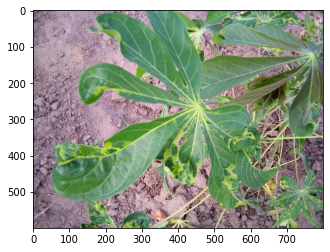

In [9]:
idx_train = np.random.randint(0, len(train_images))
idx_test = 0
img_train = cv2.imread(os.path.join(train_images_folder, train_images[idx_train]), cv2.COLOR_BGR2RGB)
img_test = cv2.imread(os.path.join(test_images_folder, test_images[idx_test]), cv2.COLOR_BGR2RGB)


img_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2RGB)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

print(img_train.shape)
print(img_train.min())
print(img_train.max())
plt.imshow(img_train)

(600, 800, 3)
0
255


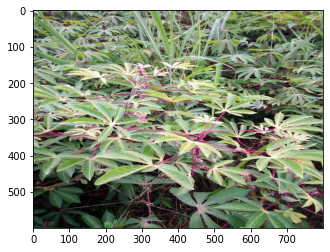

In [10]:
print(img_test.shape)
print(img_test.min())
print(img_test.max())
plt.imshow(img_test)

### **Acondicionamiento** del conjunto de datos

En este apartado vamos a dividir nuestro dataset de entrenamiento en entrenamiento-test en una proporción del 80/20 debido a que nuestra carpeta de test tan solo tiene una imagen. Tras analizar los datos en el apartado anterior hemos comprobado que la mayoría de la imágenes son de la clase 3 que corresponde a Cassava Mosaic Disease (CMD). Aún así hemos decididdo realizar una separación proporcional para todas las clases del tipo 80/20 de forma aleatoria.



In [11]:
df_total_test = pd.DataFrame()
df_total_train = pd.DataFrame()

# Recorremos la lista de etiquetas
for i in labels_number:

  #Cogemos un dataframe auxiliar de solo la etiqueta en la que estamos
  df_aux = df_training_labels[df_training_labels['label'] == i]

  # Cogemos el 25% del dataframe auxiliar para test y lo alamacenamos
  df_test = df_aux.sample(frac=0.20)
  df_total_test = pd.concat([df_total_test,df_test])

  # Cogemos el 75% restante para train y lo alamacenamos
  df_train = df_aux.drop(df_test.index)
  df_total_train = pd.concat([df_total_train,df_train])

print(df_total_test.shape)
print(df_total_train.shape)

(4279, 2)
(17118, 2)


Para la carga y dimensionalización de las imágenes vamos a recorrer los dataframes de test y train los cuales contienen los nombres de las imágenes y sus clases. Por cada imagen que recorramos la **cargaremos** en memoria desde la carpeta, **expandiremos su dimensión** y la **almacenaremos**, seguidamente almacenaremos su clase en otra variable pero manteniendo el mismo orden. Primero haremos este paso con test y luego con train. Finalmente obtendremos **testX** con la imágenes dimensionalizadas y **testY** con las etiquetas de las clases dimensionalizadas y lo mismo para train.

In [12]:
# Creamos las rutas de las carpetas de train y test
train_path = os.path.join(base_folder, "train")
test_path = os.path.join(base_folder, "test")

In [13]:
# Creamos las carpetas si no existen
def create_directories(path):
  if (not os.path.exists(path)):
    os.mkdir(path)
    # Creamos las carpetas de las clases en cada directorio
    for i in labels_dict.values():
      class_path = os.path.join(path, i)
      os.mkdir(class_path)
  else:
    print("El directorio ya existe")

In [14]:
create_directories(train_path)
create_directories(test_path)

In [19]:
# Añadimos las imágenes de train y test a su correspondiente carpeta
def copy_images(df, directory, src):
  for i in range(len(df)):
    image_name = df.iloc[i,0]
    image_label = df.iloc[i,1]
    label_name = labels_dict[str(image_label)]
    label_directory = os.path.join(directory, label_name)
    image_final_path = os.path.join(label_directory, image_name)
    if (not os.path.exists(image_final_path)):
      shutil.copy2(os.path.join(src, image_name), label_directory)

In [20]:
# Copiamos las imágenes de test y train
copy_images(df_total_test, test_path,train_images_folder)
copy_images(df_total_train, train_path, train_images_folder)

# Copiamos la única imagen de test tambien en la carpeta de test
copy_images(df_test_labels, test_path, test_images_folder)

In [15]:
# Contamos el total de imágenes para verificar que todas se han movido
def count_images(dir):
  count = 0
  for subdir, dirs, files in os.walk(dir):
      for file in files:
          if (file.endswith('.jpg')):
            count += 1
  return count

In [16]:
total_test_images = count_images(test_path)
print(f'Imágenes totales clasificadas en carpetas en test: {total_test_images}')
total_train_images = count_images(train_path)
print(f'Imágenes totales clasificadas en carpetas en train: {total_train_images}')

Imágenes totales clasificadas en carpetas en test: 4280
Imágenes totales clasificadas en carpetas en train: 17118


Ahora vamos a proceder a cargar nuestras imágenes en memoria en forma de batches para no consumir toda la RAM

In [17]:
# Variables para la carga de las imágenes
batch_size = 16
image_size = (256,256)
random_seed = 42

# Variable solo para el dataset de training
validation_split = 0.2

Para la carga de imágenes en memoria vamos a volver a realizar una distribución 80/20 de estas respectivamente en entrenamiento y validación. Esta será la segunda vez que hacemos esta distribución pero con fines distintos, la primera fue debido a las escasas imágenes de test y ahora es para la validación del entrenamiento del modelo.

In [18]:
test_ds = image_dataset_from_directory(test_path,
                                       batch_size = batch_size,
                                       image_size = image_size,
                                       seed = random_seed)

for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 4280 files belonging to 5 classes.
(16, 256, 256, 3)
(16,)


In [19]:
# Separamos nuestro conjunto de training en training y validation en una relación 80/20

train_ds = image_dataset_from_directory(train_path,
                                      batch_size = batch_size,
                                      image_size = image_size,
                                      validation_split = validation_split,
                                      subset="training",
                                      seed = random_seed)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

train_val_ds = image_dataset_from_directory(train_path,
                                      batch_size = batch_size,
                                      image_size = image_size,
                                      validation_split = validation_split,
                                      subset="validation",
                                      seed = random_seed)

for image_batch, labels_batch in train_val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 17118 files belonging to 5 classes.
Using 13695 files for training.
(16, 256, 256, 3)
(16,)
Found 17118 files belonging to 5 classes.
Using 3423 files for validation.
(16, 256, 256, 3)
(16,)


In [20]:
# Comprobamos que haya la cantidad correcta de batches. 
# Para ello dividimos el total de imágenes entre el tamaño de los batches y redondeamos hacia arriba
print(f'El tamaño del dataset de train es: {len(train_ds)}')
print(f'El total de batches que debería de existir para train es: {(total_train_images*0.8)/batch_size}')

print(f'\nEl tamaño del dataset de validación es: {len(train_val_ds)}')
print(f'El total de batches que debería de existir para validación es: {(total_train_images*0.2)/batch_size}')

print(f'\nEl tamaño del dataset de test es: {len(test_ds)}')
print(f'El total de batches que debería de existir para test es: {total_test_images/batch_size}')

El tamaño del dataset de train es: 856
El total de batches que debería de existir para train es: 855.9000000000001

El tamaño del dataset de validación es: 214
El total de batches que debería de existir para validación es: 213.97500000000002

El tamaño del dataset de test es: 268
El total de batches que debería de existir para test es: 267.5


Ahora que tenemos unos dataset divididos en batches para el entrenamiento del modelo definimos el tamaño del buffer en AUTOTUNE para que este ajsute automáticamente cuantos datos a de precargar sin sobrecargar la memoria del sistema

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_val_ds = train_val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

### Desarrollo de la **arquitectura de nuestra red**

Hemos realizados varios experimientos de distintas arquitecturas de redes. La siguiente arquitectura se trata de la arquitectura del modelo final elegido en base a los mejores resultados de precisión en entrenamiento y validación.

Nuestro base model consta de varias capas convolucionales con normalización, padding y un pooling de 2,2  y 4,4 en la última capa mientras que se aumenta progresivamente el numero de filtros de las capas consiguiendo así llevar al límite el consumo de la RAM sin excedernos de sus capacidades.

In [25]:
# Base model

inputs = Input(shape=(256, 256, 3)) # 256*256 = 65.536 pixeles por imágen

# Primer set de capas CONV => RELU => CONV => RELU => POOL
x1 = Rescaling(1/255)(inputs)
x1 = Conv2D(4, (3, 3), padding="same", activation="relu")(x1)  # 65.536 * 4 (filtros del kernel) = 262.144 parametros
x1 = BatchNormalization()(x1) 
x1 = Conv2D(4, (3, 3), padding="same", activation="relu")(x1) 
x1 = BatchNormalization()(x1) 
x1 = MaxPooling2D(pool_size=(2, 2))(x1) # El tamaño de la imagen se reduce 4 veces (128 * 128)
# Total de pixeles = 16.384 y total de parámetros = 65.536 parámetros
x1 = Dropout(0.25)(x1) 

# Segundo set de capas CONV => RELU => CONV => RELU => POOL
x2 = Conv2D(16, (3, 3), padding="same", activation="relu")(x1) # 16.384 * 16 = 262.144 parámetros
x2 = BatchNormalization()(x2)
x2 = Conv2D(16, (3, 3), padding="same", activation="relu")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2) # El tamaño de la imagen se reduce a la mitad (64 * 64)
# Total de pixeles = 4.096 y total de parámetros = 65.536 parámetros
x2 = Dropout(0.25)(x2)

# Tercer set de capas CONV => RELU => CONV => RELU => POOL
x3 = Conv2D(32, (3, 3), padding="same", activation="relu")(x2) # 4.096 * 32 = 131.072 parámetros
x3 = BatchNormalization()(x3)
x3 = Conv2D(32, (3, 3), padding="same", activation="relu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2))(x3)  # El tamaño de la imagen se reduce a la mitad (32 * 32)
# Total de pixeles = 1.024 y total de parámetros = 32.768 parámetros
x3 = Dropout(0.25)(x3)

# Cuarto set de capas CONV => RELU => CONV => RELU => POOL
x4 = Conv2D(64, (3, 3), padding="same", activation="relu")(x3) # 1.024 * 64 = 65.536 parámetros
x4 = BatchNormalization()(x4)
x4 = Conv2D(64, (3, 3), padding="same", activation="relu")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling2D(pool_size=(4, 4))(x4)  # El tamaño de la imagen se reduce a la mitad (8 * 8)
# Total de pixeles = 64 y total de parámetros = 4.096 parámetros
x4 = Dropout(0.25)(x4)

Seguidamente añadimos dos capas densas en el Top Model de 64, 16 neuronas y regularizadores y la capa densa final con la activación de softmax. Se realizaron experimentos con mas neuronas en la primera y segunda capa densa pero la RAM no era capaz de soportarlos y fallaba. Se llegaron a realizar experimentos con mas neurona pero llegaban muchos menos parámetros desde el base model por lo que los resultados finales del entrenamiento no llegaban a ser óptimos.

In [27]:
# TOP MODEL

# Primer (y único) set de capas FC => RELU
xfc = Flatten()(x4) 
xfc = Dense(64, kernel_regularizer=regularizers.l2(0.01), activation="relu", bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.001))(xfc) # 4.096 parámetros aplanados de entrada * 64 neuronas = 262.144 parámetros
xfc = BatchNormalization()(xfc)
xfc = Dense(16, kernel_regularizer=regularizers.l2(0.01), activation="relu", bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.001))(xfc)
xfc = BatchNormalization()(xfc)
xfc = Dropout(0.5)(xfc)
# Clasificador softmax
predictions = Dense(5, activation="softmax")(xfc) # Usamos softmax ya que es un clasificador de probabilidad

In [23]:
model_cnn = Model(inputs=inputs, outputs=predictions)
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 4)       112       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 4)      16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 4)       148       
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 4)      16        
 hNormalization)                                             

También decidimos añadir otro metodo de regularización conocido como la parada temprana con una "paciencia" de 15 épocas. Además añadimos el callback de checkopoints para poder guardar el entrenamiento de la red neuronal y proseguir con él en cualquier momento.

In [24]:
# Precontruimos la red con la función de péridas, de optimización y las métricas

model_cnn.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=Adam(learning_rate=0.003,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
                  metrics=["accuracy"])


In [31]:
es = EarlyStopping(monitor="val_loss", min_delta=0, patience=7, verbose=1, mode="min", restore_best_weights=True)
mc = ModelCheckpoint(filepath=relative_notebook_path+'/standard_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
H = model_cnn.fit(train_ds, validation_data=train_val_ds, epochs=50, verbose=1, callbacks = [es, mc])

Epoch 1/50
1604/1605 [============================>.] - ETA: 0s - loss: 1.7856 - accuracy: 0.5780
Epoch 1: val_loss improved from inf to 1.28028, saving model to /content/drive/MyDrive/Practica/standard_model.hdf5
1605/1605 [==============================] - 40s 24ms/step - loss: 1.7852 - accuracy: 0.5781 - val_loss: 1.2803 - val_accuracy: 0.6310
Epoch 2/50
1603/1605 [============================>.] - ETA: 0s - loss: 1.3418 - accuracy: 0.6109
Epoch 2: val_loss improved from 1.28028 to 1.19800, saving model to /content/drive/MyDrive/Practica/standard_model.hdf5
1605/1605 [==============================] - 39s 24ms/step - loss: 1.3418 - accuracy: 0.6108 - val_loss: 1.1980 - val_accuracy: 0.6273
Epoch 3/50
1604/1605 [============================>.] - ETA: 0s - loss: 1.4189 - accuracy: 0.6133
Epoch 3: val_loss did not improve from 1.19800
1605/1605 [==============================] - 37s 23ms/step - loss: 1.4189 - accuracy: 0.6132 - val_loss: 1.4633 - val_accuracy: 0.6080
Epoch 4/50
1603/16

In [ ]:
model_cnn.save(relative_notebook_path+"/standard_model.h5")

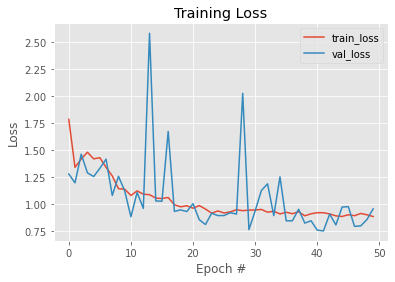

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

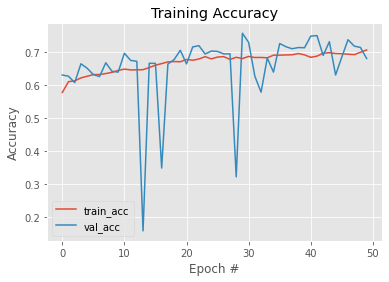

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
true_label = np.concatenate([y for _, y in test_ds], axis=0)
print(true_label.shape)
test_images = np.concatenate([x for x,_ in test_ds], axis=0)
print(test_images.shape)

(5436,)
(5436, 256, 256, 3)


In [ ]:
predictions = model_cnn.predict(test_images, verbose=1)

170/170 [==============================] - 4s 18ms/step


In [ ]:
label_names = list(labels_dict.values())
print(classification_report(true_label, predictions.argmax(axis=1), target_names=label_names, zero_division=0))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00       358
Cassava Brown Streak Disease (CBSD)       0.13      0.03      0.05       547
         Cassava Green Mottle (CGM)       0.13      0.03      0.04       596
       Cassava Mosaic Disease (CMD)       0.61      0.90      0.73      3290
                            Healthy       0.15      0.08      0.10       645

                           accuracy                           0.56      5436
                          macro avg       0.20      0.21      0.18      5436
                       weighted avg       0.41      0.56      0.46      5436



### **Data augmentation**

Para nuestro **data augmentation** hemos definido un generador el cual realiza distintas transformaciones a nuestras imágenes de entrenamiento.

In [22]:

train_datagen = ImageDataGenerator(
    rotation_range=40, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    validation_split=0.2,
    shear_range=0.2, # deslizamiento
    zoom_range=0.2, # rango de zoom
    vertical_flip = True,
    samplewise_center=True)

Cuando hemos definido el generador se ha definido también la proporción de validación, continuamos con el 80/20. Definiendo esto en el generador a la hora de realizar el **data augmentaiton** sobre las imágenes solo hemos de indicar el subset que queremos que se genere.

In [23]:
training_ds = train_datagen.flow_from_directory(train_path, target_size=image_size, batch_size=batch_size, 
                                          class_mode = 'sparse', subset="training",seed=42)
validation_ds = train_datagen.flow_from_directory(train_path, target_size=image_size, batch_size=batch_size, 
                                            class_mode = 'sparse', subset="validation",seed=42)

Found 13696 images belonging to 5 classes.
Found 3422 images belonging to 5 classes.


In [28]:
model_da = Model(inputs=inputs, outputs=predictions)
model_da.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 4)       112       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 4)      16        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 4)       148       
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 4)      16        
 hNormalization)                                             

In [30]:
model_da.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=Adam(learning_rate=0.003,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), 
                  metrics=["accuracy"])

mc_aug = ModelCheckpoint(filepath=relative_notebook_path+'/data_aug_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [32]:
H_aug = model_da.fit(training_ds, validation_data=validation_ds, steps_per_epoch=len(training_ds), epochs=50, verbose=1, callbacks=[es, mc_aug])

Epoch 1/50
856/856 [==============================] - ETA: 0s - loss: 1.7950 - accuracy: 0.5602
Epoch 1: val_loss improved from inf to 1.33793, saving model to /content/drive/MyDrive/Master AI/Redes neuronales/Practica/data_aug_model.hdf5
856/856 [==============================] - 446s 505ms/step - loss: 1.7950 - accuracy: 0.5602 - val_loss: 1.3379 - val_accuracy: 0.6201
Epoch 2/50
856/856 [==============================] - ETA: 0s - loss: 1.2380 - accuracy: 0.6194
Epoch 2: val_loss improved from 1.33793 to 1.19218, saving model to /content/drive/MyDrive/Master AI/Redes neuronales/Practica/data_aug_model.hdf5
856/856 [==============================] - 415s 485ms/step - loss: 1.2380 - accuracy: 0.6194 - val_loss: 1.1922 - val_accuracy: 0.6186
Epoch 3/50
856/856 [==============================] - ETA: 0s - loss: 1.2219 - accuracy: 0.6270
Epoch 3: val_loss did not improve from 1.19218
856/856 [==============================] - 410s 479ms/step - loss: 1.2219 - accuracy: 0.6270 - val_loss: 

In [33]:
model_da.save(relative_notebook_path+"/data_aug_model.h5")

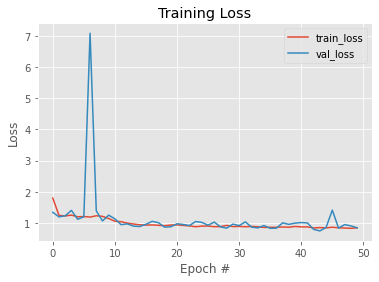

In [34]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H_aug.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H_aug.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

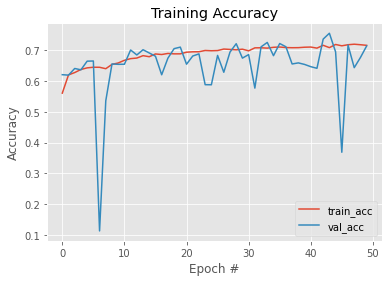

In [35]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H_aug.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H_aug.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [37]:
predictions_da = model_da.predict(test_images, verbose=1)

134/134 [==============================] - 2s 14ms/step


In [38]:
print(predictions_da.shape)

(4280, 5)


In [39]:
label_names = list(labels_dict.values())
print(classification_report(true_label, predictions_da.argmax(axis=1), target_names=label_names, zero_division=0))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.00      0.00      0.00       217
Cassava Brown Streak Disease (CBSD)       0.10      0.15      0.12       438
         Cassava Green Mottle (CGM)       0.11      0.11      0.11       477
       Cassava Mosaic Disease (CMD)       0.62      0.71      0.66      2632
                            Healthy       0.09      0.03      0.04       516

                           accuracy                           0.47      4280
                          macro avg       0.18      0.20      0.19      4280
                       weighted avg       0.41      0.47      0.44      4280



Como podemos comprobar usando **Data Augmentation** se consiguen mejorar la precisión total del modelo. 

### **Resultados** redes propias


En la siguiente tabla se recogen los experimentos realizados. En ella se recogen los parámetros que más variación han experimentado en nuestro modelo, aunque existen otros que también han cambiado como el número de capas convolucionales y sus filtros. Sin embargo, estos cambios han sido leves y siempre la arquitectura en ese aspecto ha sido muy parecida a la final. Además, se han realizado muchas pruebas pero se ha pretendido recoger las más relevantes en aras de sintetizar. 

| Índice | Batch size | Dropout | Weight and bias regularization | First Dense | Dense number | accuracy-val_accuracy |
|:-----|:-----|:---------|:-----|:---------|:-----|:-----|
| 1 | 16 | 0.25 | NO | 256 | 3+1 | 0.87-0.64 |
| 2 | 16 | 0.7 | SÍ | 256 | 3+1 | 0.64-0.66 |
| 3 | 16 | 0.5 | NO | 256 | 3+1 | 0.83-0.72 |
| 4 | 16 | 0.25 | NO | 64 | 2+1 | 0.83-0.67 |
| 5 | 8 | 0.25 | SÍ | 128 | 2+1 | 0.72-0.71 |
| 6 | 4 | 0.25 | SÍ | 64 | 2+1 | 0.62-0.67 |
| 7 | 8 | 0.25 | SÍ | 64 | 2+1 | 0.69-0.75 |


En primer lugar, se partió de un batch size mucho mayor al orden de esta tabla (128, 256...) que imposibilitaba el entrenamiento del modelo por limitaciones de espacio en la memoria RAM (aún realizando el trabajo con Colab PRO). Tal y como se vio en teoría, el batch size está limitado en grandes datasets como este. Por ello, se redujo este parámetro y se comenzó a obtener resultados entrenando modelos.

Las primeras pruebas fueron con un batch size de 2 consiguiendo asi no sobrecargar la RAM pero este fue rapidamente aumentado debido a los malos resultados de la red. Así, en el modelo 1 de la tabla se optó por un batch_size de 16, con tres capas densas junto a la final de predicción con la activación softmax, teniendo en la primera capa densa 256 neuronas. El resultado en training fue muy bueno, pero había gran overfitting que debía reducirse. 

Para reducirlo, se aumentó considerablemente el dropout y se incluyó weight y bias regularization (L1 y L2), sin variar el resto de parámetros. Cayó la precisión de entrenamiento enormemente sin apenas aumentar la de validación, por lo que se redujo el dropout y se eliminó la regularización de pesos, dando lugar al modelo 3. Los resultados habían mejorado considerablemente pero el overfitting era muy apreciable.

De esta manera, se optó por eliminar una capa densa y reducir de 256 a 64 las neuronas de la primera capa. No se consiguió mejorar (modelo 4), así que se aumentaron las neuronas de la primera capa densa, se volvió a utilizar regularización de pesos y sesgos y se redujo el batch size a 8. Así, el modelo 5 dio unas curvas muy relacionadas entre entrenamiento y validación junto a unos valores de precisión aceptables. Posteriores modificaciones de este modelo dieron lugar al 6 y finalmente al 7, que es la configuración final elegida y mostrada en el documento.

El modeloo final con el cuál nos quedamos es la arquitectura sin **Data Augmentation** ya que este es mejor y tiene una ejecución mucho más rápida.

### Introducción redes **pre-entrenadas**


Vovlemos a crear unos dataset para el entrenamiento del modelo.

In [40]:
# Variables para la carga de las imágenes
batch_size = 16
image_size = (300,300)
random_seed = 42

# Variable solo para el dataset de training
validation_split = 0.2

In [41]:
test_ds = image_dataset_from_directory(test_path,
                                       batch_size = batch_size,
                                       image_size = image_size,
                                       seed = random_seed)

for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 4280 files belonging to 5 classes.
(16, 300, 300, 3)
(16,)


In [42]:
# Separamos nuestro conjunto de training en training y validation en una relación 80/20

train_ds = image_dataset_from_directory(train_path,
                                      batch_size = batch_size,
                                      image_size = image_size,
                                      validation_split = validation_split,
                                      subset="training",
                                      seed = random_seed)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

train_val_ds = image_dataset_from_directory(train_path,
                                      batch_size = batch_size,
                                      image_size = image_size,
                                      validation_split = validation_split,
                                      subset="validation",
                                      seed = random_seed)

for image_batch, labels_batch in train_val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 17118 files belonging to 5 classes.
Using 13695 files for training.
(16, 300, 300, 3)
(16,)
Found 17118 files belonging to 5 classes.
Using 3423 files for validation.
(16, 300, 300, 3)
(16,)


#### **InceptionResNetV2**

La primera red pre-entrenada que hemos utilizado ha sido InceptionResNetV2 utilizando los pesos del dataset de **imagenet**

##### Transfer Learnig

Hemos realizado un transfer learning en el cuál hemos añadido un Top Model secuencial y el output con una activación del tipo softmax debido a la casuística de nuestro dataset

In [43]:
base_inception_model = InceptionResNetV2(include_top=False, weights='imagenet',input_shape=[300,300,3])
model_inception = Sequential()
model_inception.add(base_inception_model)
model_inception.add(GlobalAveragePooling2D())
model_inception.add(Flatten())
model_inception.add(Dense(1024, activation = 'relu', bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.001)))
model_inception.add(Dropout(0.3))
model_inception.add(Dense(512, activation = 'relu'))
model_inception.add(Dropout(0.3))
model_inception.add(Dense(5, activation='softmax'))

219070464/219055592 [==============================] - 3s 0us/step


In [44]:
model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_1 (Flatten)         (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1573888   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               5

A la hora de compilar el modelo hemos continuando usando la misma función de perdidas y el mismo optimizador pero en este caso reduciendo la tasa de aprendizaje.

In [45]:
# Precontruimos la red con la función de péridas, de optimización y las métricas
model_inception.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=Adam(learning_rate=0.0001), 
                  metrics=["accuracy"])

También se han definido los callback de parada temprana y de realizar puntos de guardado para la carga del modelo desde el último punto para poder continuar con el entramiento si este lo requiere.

In [46]:
es_inception = EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min", restore_best_weights=True)
mc_inception = ModelCheckpoint(filepath=relative_notebook_path+'/inception_model.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1, save_weights_only = False)

In [47]:
H_inception = model_inception.fit(training_ds, 
                    validation_data = validation_ds, 
                    steps_per_epoch=len(training_ds), 
                    epochs=50, 
                    verbose=1, 
                    callbacks=[es_inception, mc_inception])

Epoch 1/50
856/856 [==============================] - ETA: 0s - loss: 0.7570 - accuracy: 0.7278
Epoch 1: val_loss improved from inf to 3.12457, saving model to /content/drive/MyDrive/Master AI/Redes neuronales/Practica/inception_model.hdf5
856/856 [==============================] - 476s 528ms/step - loss: 0.7570 - accuracy: 0.7278 - val_loss: 3.1246 - val_accuracy: 0.7472
Epoch 2/50
856/856 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.8031
Epoch 2: val_loss did not improve from 3.12457
856/856 [==============================] - 434s 507ms/step - loss: 0.5652 - accuracy: 0.8031 - val_loss: 8.0054 - val_accuracy: 0.7957
Epoch 3/50
856/856 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.8262
Epoch 3: val_loss did not improve from 3.12457
856/856 [==============================] - 433s 506ms/step - loss: 0.5118 - accuracy: 0.8262 - val_loss: 4.3223 - val_accuracy: 0.7951
Epoch 4/50
856/856 [==============================] - ETA: 0s - loss:

In [48]:
model_inception.save(relative_notebook_path+"/inception_model.h5")

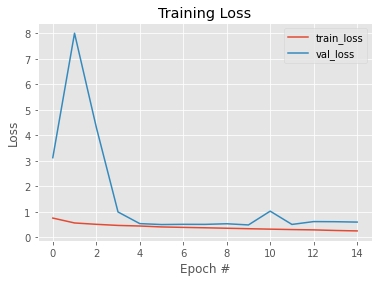

In [51]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H_inception.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H_inception.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

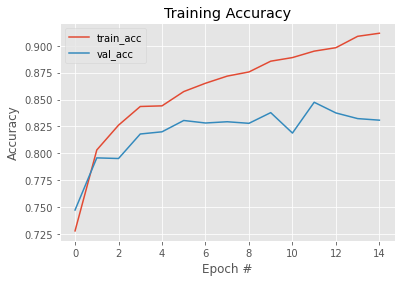

In [52]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H_inception.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 15), H_inception.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [55]:
true_label = np.concatenate([y for _, y in test_ds], axis=0)
print(true_label.shape)
test_images = np.concatenate([x for x,_ in test_ds], axis=0)
print(test_images.shape)

(4280,)
(4280, 300, 300, 3)


In [56]:
predictions = model_inception.predict(test_images, verbose=1)

134/134 [==============================] - 29s 177ms/step


In [57]:
label_names = list(labels_dict.values())
print(classification_report(true_label, predictions.argmax(axis=1), target_names=label_names, zero_division=0))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.04      0.03      0.04       217
Cassava Brown Streak Disease (CBSD)       0.11      0.20      0.14       438
         Cassava Green Mottle (CGM)       0.10      0.05      0.07       477
       Cassava Mosaic Disease (CMD)       0.62      0.52      0.57      2632
                            Healthy       0.12      0.21      0.16       516

                           accuracy                           0.37      4280
                          macro avg       0.20      0.20      0.19      4280
                       weighted avg       0.42      0.37      0.39      4280



##### Fine Tuning

Añadamos **Fine Tuning**

In [58]:
print("Estas son todas las capas de InceptionResNetV2: ")
for layer in base_inception_model.layers:
    print(layer.name)

print(len(base_inception_model.layers))

Estas son todas las capas de InceptionResNetV2: 
input_2
conv2d_8
batch_normalization_10
activation
conv2d_9
batch_normalization_11
activation_1
conv2d_10
batch_normalization_12
activation_2
max_pooling2d_4
conv2d_11
batch_normalization_13
activation_3
conv2d_12
batch_normalization_14
activation_4
max_pooling2d_5
conv2d_16
batch_normalization_18
activation_8
conv2d_14
conv2d_17
batch_normalization_16
batch_normalization_19
activation_6
activation_9
average_pooling2d
conv2d_13
conv2d_15
conv2d_18
conv2d_19
batch_normalization_15
batch_normalization_17
batch_normalization_20
batch_normalization_21
activation_5
activation_7
activation_10
activation_11
mixed_5b
conv2d_23
batch_normalization_25
activation_15
conv2d_21
conv2d_24
batch_normalization_23
batch_normalization_26
activation_13
activation_16
conv2d_20
conv2d_22
conv2d_25
batch_normalization_22
batch_normalization_24
batch_normalization_27
activation_12
activation_14
activation_17
block35_1_mixed
block35_1_conv
block35_1
block35_1_a

La última capa de **InceptionResNetV2** es *convo_7b_ac*

In [59]:
last_layer = base_inception_model.get_layer('conv_7b_ac')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 8, 8, 1536)


In [60]:
# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# En base_inception_model.layers.name tenemos la información del nombre de la capa
for layer in base_inception_model.layers: 
  if layer.name == 'conv_7b_ac': # CAMBIAR AQUÍ NOMBRE HASTA QUE CAPA CONGELAMOS
    break 
  layer.trainable = False 
  print('Capa ' + layer.name + ' congelada...') 

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_inception_model.layers[-1].output 


Capa input_2 congelada...
Capa conv2d_8 congelada...
Capa batch_normalization_10 congelada...
Capa activation congelada...
Capa conv2d_9 congelada...
Capa batch_normalization_11 congelada...
Capa activation_1 congelada...
Capa conv2d_10 congelada...
Capa batch_normalization_12 congelada...
Capa activation_2 congelada...
Capa max_pooling2d_4 congelada...
Capa conv2d_11 congelada...
Capa batch_normalization_13 congelada...
Capa activation_3 congelada...
Capa conv2d_12 congelada...
Capa batch_normalization_14 congelada...
Capa activation_4 congelada...
Capa max_pooling2d_5 congelada...
Capa conv2d_16 congelada...
Capa batch_normalization_18 congelada...
Capa activation_8 congelada...
Capa conv2d_14 congelada...
Capa conv2d_17 congelada...
Capa batch_normalization_16 congelada...
Capa batch_normalization_19 congelada...
Capa activation_6 congelada...
Capa activation_9 congelada...
Capa average_pooling2d congelada...
Capa conv2d_13 congelada...
Capa conv2d_15 congelada...
Capa conv2d_18 con

In [61]:
x_ft_inception = GlobalAveragePooling2D()(last)
x_ft_inception = Flatten()(x_ft_inception)
x_ft_inception = Dense(1024, activation = 'relu', bias_regularizer=regularizers.L1L2(l1=0.01, l2=0.001))(x_ft_inception)
x_ft_inception = Dropout(0.3)(x_ft_inception)
x_ft_inception = Dense(512, activation = 'relu')(x_ft_inception)
x_ft_inception = Dropout(0.3)(x_ft_inception)
x_ft_inception = Dense(5, activation = "softmax")(x_ft_inception)

model_inception_ft = Model(base_inception_model.input, x_ft_inception)
model_inception_ft.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 149, 149, 32  96         ['conv2d_8[0][0]']               
 ormalization)                  )                                                           

A la hora de compilar el modelo hemos continuando usando la misma función de perdidas y el mismo optimizador pero en este caso reduciendo la tasa de aprendizaje.

In [62]:
# Precontruimos la red con la función de péridas, de optimización y las métricas
model_inception_ft.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=Adam(learning_rate=0.0001), 
                  metrics=["accuracy"])

También se han definido los callback de parada temprana y de realizar puntos de guardado para la carga del modelo desde el último punto para poder continuar con el entramiento si este lo requiere.

In [63]:
mc_ft_inception = ModelCheckpoint(filepath=relative_notebook_path+'/inception_ft.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1, save_weights_only = False)

In [64]:
H_ft_inception = model_inception_ft.fit(training_ds, 
                    validation_data = validation_ds, 
                    steps_per_epoch=len(training_ds), 
                    epochs=50, 
                    verbose=1, 
                    callbacks=[es_inception, mc_ft_inception])

Epoch 1/50
856/856 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.9002
Epoch 1: val_loss improved from inf to 0.53826, saving model to /content/drive/MyDrive/Master AI/Redes neuronales/Practica/inception_ft.hdf5
856/856 [==============================] - 480s 547ms/step - loss: 0.3007 - accuracy: 0.9002 - val_loss: 0.5383 - val_accuracy: 0.8434
Epoch 2/50
856/856 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.9160
Epoch 2: val_loss improved from 0.53826 to 0.49780, saving model to /content/drive/MyDrive/Master AI/Redes neuronales/Practica/inception_ft.hdf5
856/856 [==============================] - 449s 525ms/step - loss: 0.2535 - accuracy: 0.9160 - val_loss: 0.4978 - val_accuracy: 0.8451
Epoch 3/50
856/856 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9176
Epoch 3: val_loss did not improve from 0.49780
856/856 [==============================] - 432s 505ms/step - loss: 0.2448 - accuracy: 0.9176 - val_loss: 0.55

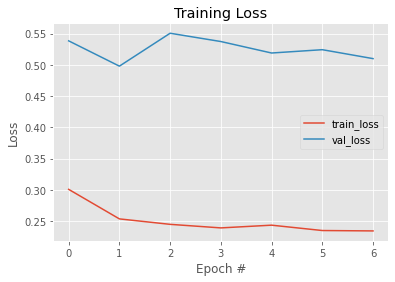

In [66]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 7), H_ft_inception.history["loss"], label="train_loss")
plt.plot(np.arange(0, 7), H_ft_inception.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

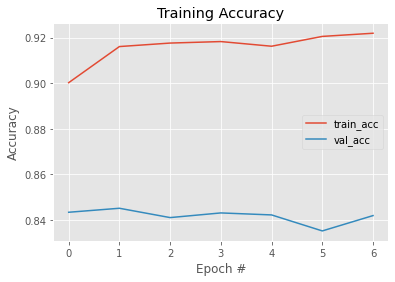

In [67]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 7), H_ft_inception.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 7), H_ft_inception.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [68]:
predictions_inception_ft = model_inception_ft.predict(test_images, verbose=1)

134/134 [==============================] - 27s 173ms/step


In [69]:
label_names = list(labels_dict.values())
print(classification_report(true_label, predictions_inception_ft.argmax(axis=1), target_names=label_names, zero_division=0))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.03      0.01      0.02       217
Cassava Brown Streak Disease (CBSD)       0.11      0.16      0.13       438
         Cassava Green Mottle (CGM)       0.10      0.04      0.05       477
       Cassava Mosaic Disease (CMD)       0.62      0.59      0.60      2632
                            Healthy       0.12      0.19      0.15       516

                           accuracy                           0.41      4280
                          macro avg       0.19      0.20      0.19      4280
                       weighted avg       0.42      0.41      0.41      4280



### **Resultados** redes pre-entrenadas

Las arquitecturas de redes pre-entrenadas que hemos utilizado han sido **InceptionResNetV2** y **EfficientNetB3**. La red con mayor precisión final ha sido InceptionResNetV2. Para el desarrollo de ambas arquitecturas se han usado distintas técnicas de regularización y tareas de **transfer learning** y **fine tuning**. Aún aplicando estas técnicas InceptionResNetV2 siempre ha sido la arquitectura que mejores resultados obtenido y mas rapido convergía.

| Arquitectura | Accurracy |
|:-----|:-----|
| Inception with Transfer Learning | 0.37 | 
| Efficient with Transfer Learning | 0.35 |
| Inception with Fine Tuning | 0.41 |
| Efficient with Fine Tuning | 0.37 |

COmo podemos ver en los resultados de la tabla superior la red pre-entrenada de Inception tiene mejores resultados que Efficient y aplicando la técnica de Fine Tuning sobre la última capa tiene una notable mejora.

## Conclusiones

Tras varios experimientos con nuestra red propia y con las redes pre-entrenadas de **Inception** y **Efficient** hemos llegado a la conclusión de que las redes pre-entrenadas tienen un reusltado significativamente peor al de nuestra arquitectura. La redes pre-entrenadas aprenden más rápido y mejor para las muestras de entrenamiento y validación pero la preddicción sobre test no es tan buena como la de nuestra arquitectura. Además estas consiguen una convergencia mas temprana y son más óptimas respecto a la consumición de recursos de la máquina. Sin embargo, eL paso de cada época de nuestra arquitectura se realzia mas rapidamente.

Respecto a la técnica de **Data Augmentation** nos hemos encontrado con arquitecturas mas lentas y mejoras en el rendimiento para ciertas clases y empeora en otras pero una mejora en el rendimiento global.

## Posibles mejoras

Una de las principales mejoras que se podría realizar sobre las arquitecturas de este proyecto es la creación de un dataset de entrenamiento balanceado con la misma cantidad de imágenes para todas las clases ya que como hemos comprobado las redes aprenden mejor la clases que contiene más muestras de entrenamiento y para las demás obtienen muy malos resultados. Con un dataset balanceado la técnica de **Data Augmentation** podría tener un mayor potencial que con la casuística actual.

Otra mejora que se puede aplicar es ampliar el uso del **Fine Tuning** sobre la red pre-entrenada de **Inception** ya que descongelando tan solo la última capa se consigue una notable mejora sería una buena propuesta descongelar mas capas y entrenar de nuevo la red.

In [76]:
%%capture
name_IPYNB_file = 'Cassava-CNN-classificaiton.ipynb'
get_ipython().system(
"apt update >> /dev/null && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended >> /dev/null"
)
get_ipython().system("jupyter nbconvert --output-dir='$relative_notebook_path' '$relative_notebook_path'/'$name_IPYNB_file' --to pdf")